# How to use Neo4J with LinkML-Store

This how-to guide shows you how to use linkml-store over a Neo4j database. linkml-store is a flexible framework that can be used with different backends, employing simple mappings via LinkML schemas.

One of the main use cases here is being able to provide a schema for validating a property graph database, as well as making it easier to map between a property graph database and other representations (tabular/dataframe, JSON/YAML, RDF, RDFstar, OWL, ...)

We will try and use some of the same examples as in [neo4j graph concepts guide](https://neo4j.com/docs/getting-started/appendix/graphdb-concepts/), making a simple Movie-oriented KG:

![neo4j graph concepts](../images/graph_simple-arr.svg)

## Running this how-to guide interactively.

This guide is both documentation, and a Jupyter notebook.

You can run the notebook locally. You will need a local neo4j database running, with authentication disabled.

One way to do this is via Docker:    

```bash
docker run
  --name myneo4j
  --publish 7474:7474
  --publish 7687:7687
  --volume $HOME/neo4j/data/:/data 
  --volume $HOME/neo4j/logs/:/logs
  -e NEO4J_AUTH=none
  neo4j
```    

__IMPORTANT NOTE__ if you run this Notebook locally, it will overwrite the default `neo4j`. If you have the enterprise edition
you can modify this notebook to use a different database.

In [1]:
from linkml_store import Client

client = Client()

Ensure the database is empty, then connect

In [2]:
db = client.attach_database("neo4j", "test")
db.drop()
db = client.attach_database("neo4j", "test")

## Using a schema

It is not necessary to defined a LinkML schema in advance, but this has a lot of advantages:

- validation
- clarity for producers and consumers
- declarative mappings and graph projections

We'll use a predefined one here. You can see the source schemasheet [here](https://docs.google.com/spreadsheets/d/1oMrzA41tg_nisdWInnqKJrcvv30dOXuwAhznJYYPSB8/edit?gid=1499822522#gid=1499822522)

In [3]:
db.load_schema_view("input/movies_kg/schema.yaml")

Next we'll visualization this using PlamtUML

In [4]:
%%bash
gen-plantuml --directory input/movies_kg/diagrams input/movies_kg/schema.yaml

![UML Schema](input/movies_kg/diagrams/MoviesKG.svg)

Note that this is in many respects a "normal" UML type schema, with classes and class relationships.

Here we define to base classes `Node` and `Edge`. We are treating edges as first-class entities in the model.
We are following conventions and using `subject` and `object` for the head and tail nodes.

You don't *need* to define your schema this way. In fact it's possible to map **any** LinkML schema to a property graph. You don't need
classes like "Node" and "Edge", and you don't need a reification type model.
    
But having this kind of "explicit" model is easiest to make the relationship to Neo4J easier to grok.

## Create Node and Edge collections

We create two collections, one for nodes, and one for edges.

Note: you can organize collections how you like - you could have multiple node collections,
(e.g. different collections for persons, movies), and multiple edge collections. However, you can't mix
nodes and edges in one collection. 

In [5]:
node_collection = db.create_collection("Node", alias="nodes", recreate_if_exists=True)
edge_collection = db.create_collection("Edge", alias="nodes", recreate_if_exists=True)

It's necessary to provide some kind of mechanism to indicate which collections are edge collections.
This can be inferred from the schema, but here will will make it explicit.

We'll use a default edge projections, which assigns special meaning to `subject`, `predicate`, and `object`.

In [6]:
from linkml_store.graphs.graph_map import EdgeProjection

edge_collection.metadata.graph_projection = EdgeProjection()

## Adding Data

In [7]:
# For convenience, we assign constants for each of the identifiers in the database
TH = "ACTOR:TH"
RZ = "ACTOR:RZ"
FG = "MOVIE:FG"
BTTF = "MOVIE:BTTF"
FGC = "CHARACTER:FGC"

In [8]:
persons = [
    { "id": TH, "category": "Actor", "name": "Tom Hanks"},
    { "id": RZ, "category": "Director", "name": "Robert Zemekis"},
]
movies = [
    { "id": FG, "category": "Movie", "name": "Forest Gump"},
]
characters = [
    { "id": FGC,"category": "Character", "name": "Forest Gump (Character)"},
]


In [9]:
edges = [
    {"subject": RZ, "predicate": "Directed", "object": FG},
    {"subject": TH, "predicate": "ActedIn", "object": FG, "plays": FGC},
]

In [10]:
# Modify this to experiment with different ways of adding
ADD_INDIVIDUALLY = True

In [11]:
if ADD_INDIVIDUALLY:
    node_collection.insert(persons)
    node_collection.insert(movies)
    node_collection.insert(characters)
    edge_collection.insert(edges)
else:
    g = {
        "nodes": persons + movies + characters,
        "edges": edges
    }
    db.insert(g)

## Visualization

We will visualize the whole database using py2neo, networkx, and matplotlib.
This is not as visually attractive as the native neo4j UI but it works better in a notebook:

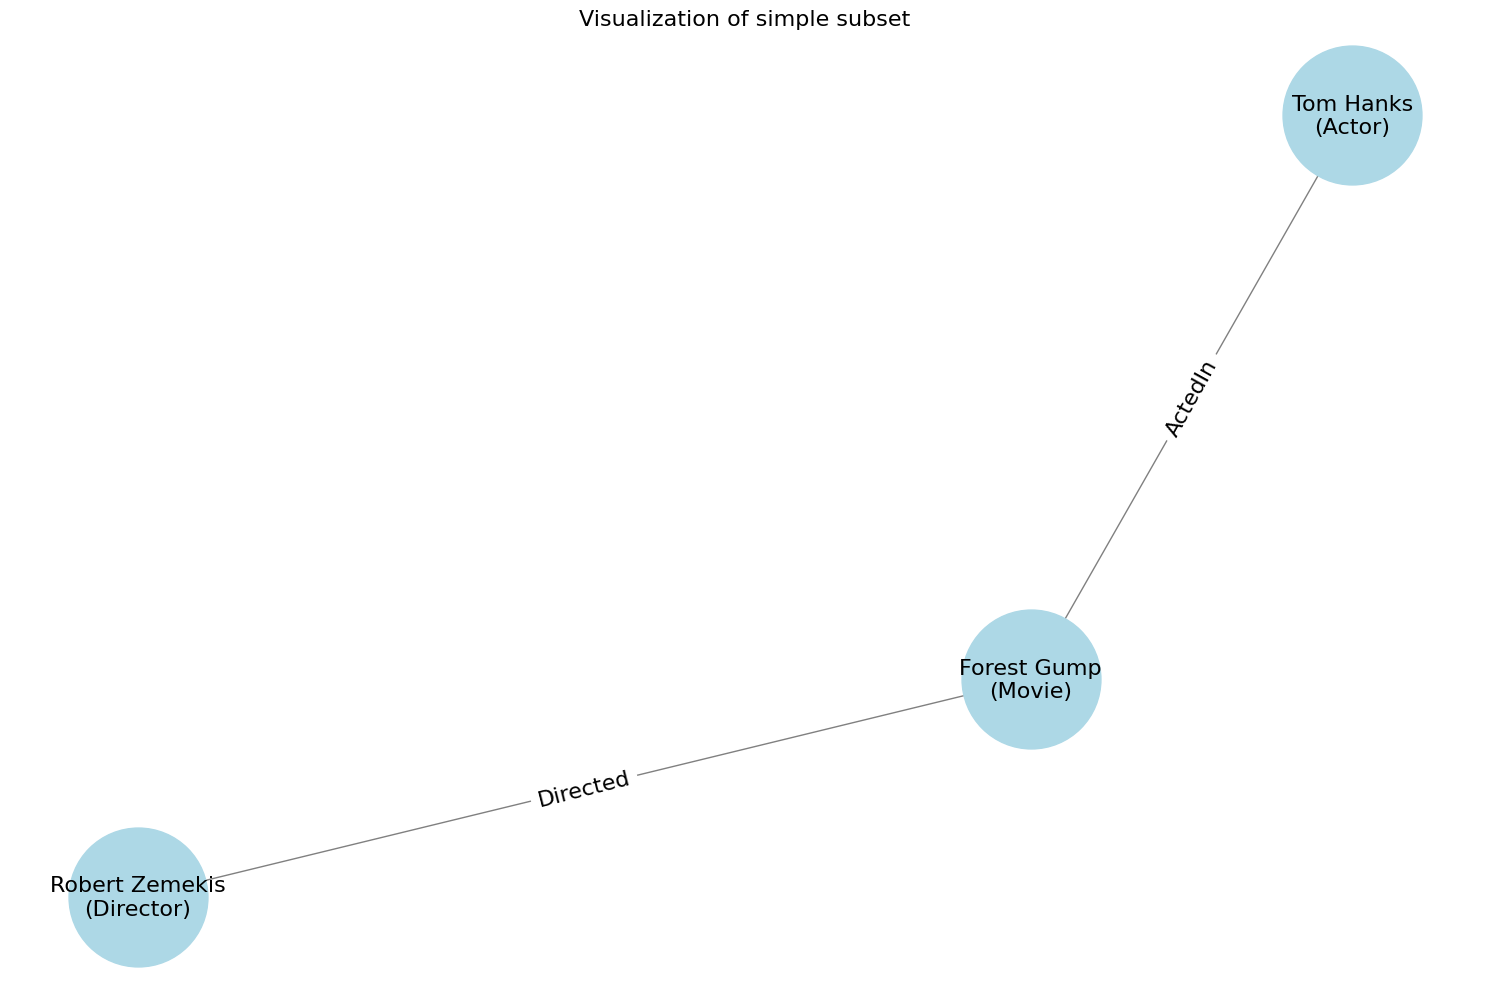

In [12]:
import matplotlib.pyplot as plt
from linkml_store.utils.neo4j_utils import draw_neo4j_graph

plt.figure(figsize=(15, 10))
draw_neo4j_graph()
plt.title("Visualization of simple subset", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

Note this doesn't display edge properties (e.g. the "plays" edge property between Tom Hanks and Forrest Gump

### Exploring in Neo4j

If we go on over to http://localhost:7474/browser/ (if you are running this locally) you can see this in the normal UI:

![neo4j screenshot of single edge](../images/neo4j-screenshot-1.png)

## Validation

One of the main use cases for LinkML and LinkML-Store is validation using a schema. Most of the rich features of LinkML validation
are available for property graphs, we will illustrate some simple ones here.

### Validating an existing database

First we'll validate the database. Note that by default, validation is retrospective; it's possible to insert invalid data into the database.

In [13]:
errs = list(db.iter_validate_database())
errs

[]

Good, no errors!

### Prospective Validation

We can switch on prospective validation, to prevent any future modifications making the data invalid:

In [14]:
edge_collection.metadata.validate_modifications = True


Let's test this out by inserting deliberately invalid data -- making up an edge property not defined
in the schema

In [15]:
try:
    edge_collection.insert({ "subject": RZ, "predicate": "Directed", "object": BTTF, "date": 1985})
except Exception as e:
    print("Got an exception (we expect this!!!)")
    print(e)

Got an exception (we expect this!!!)
Validation errors: [ValidationResult(type='jsonschema validation', severity=<Severity.ERROR: 'ERROR'>, message="Additional properties are not allowed ('date' was unexpected) in /", instance={'subject': 'ACTOR:RZ', 'predicate': 'Directed', 'object': 'MOVIE:BTTF', 'date': 1985}, instance_index=0, instantiates='Directed', context=[])]


We can also test referential integrity. By default, inserting an edge that points to a non-existent node will
create a dangling node in Neo4j (Neo4j enforces that there must be some kind of node).

We will change the policy and try and insert a dangling edge

In [16]:
from linkml_store.api.stores.neo4j.neo4j_collection import DeletePolicy

edge_collection.delete_policy = DeletePolicy.ERROR

try:
    edge_collection.insert({ "subject": RZ, "predicate": "Directed", "object": "MOVIE:MADE_UP_NODE"})
except Exception as e:
    print("Got an exception (we expect this!!!)")
    print(e)

Got an exception (we expect this!!!)
Node with identifier MOVIE:MADE_UP_NODE not found in the database.


## Loading Data from a file

Loading data into a graph is very much like loading any other data into a LinkML schema. So long as you conform
to the schema we defined above (which has defined graph projections), then it can be loaded into Neo4J.

Data could be combined in a single JSON file, but it's also convenient to use tabular or dataframe-oriented formats.

Here we will load from CSV

In [17]:
import pandas as pd


In [18]:
nodes_df = pd.read_csv("input/movies_kg/nodes.csv").convert_dtypes()
nodes_df

,id,category,name,born,released
0,PERSON:TH,Actor,Tom Hanks,1956,<NA>
1,PERSON:RZ,Director,Robert Zemeckis,1951,<NA>
2,PERSON:HW,Actor,Hugo Weaving,1960,<NA>
3,PERSON:KR,Actor,Keanu Reeves,1964,<NA>
4,PERSON:MJF,Actor,Michael J. Fox,1961,<NA>
5,MOVIE:FG,Movie,Forrest Gump,<NA>,1994
6,MOVIE:TM,Movie,The Matrix,<NA>,1999
7,MOVIE:TM2,Movie,The Matrix Reloaded,<NA>,2003
8,MOVIE:TM3,Movie,The Matrix Revolutions,<NA>,2003
9,MOVIE:BTTF,Movie,Back to the Future,<NA>,1985


In [19]:
edges_df = pd.read_csv("input/movies_kg/edges.csv").convert_dtypes()
edges_df

,subject,predicate,object,plays
0,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
1,PERSON:RZ,Directed,MOVIE:FG,<NA>
2,PERSON:RZ,Directed,MOVIE:BTTF,<NA>
3,PERSON:KR,ActedIn,MOVIE:TM,CHARACTER:Neo
4,PERSON:MJF,ActedIn,MOVIE:BTTF,CHARACTER:MartyMcFly
5,PERSON:HW,ActedIn,MOVIE:TM,CHARACTER:AgentSmith


In [20]:
node_collection.insert(nodes_df.to_dict(orient="records"))

In [21]:
# TODO: use type designator in validation 
edge_collection.metadata.validate_modifications = True

In [22]:
edge_collection.insert(edges_df.to_dict(orient="records"))

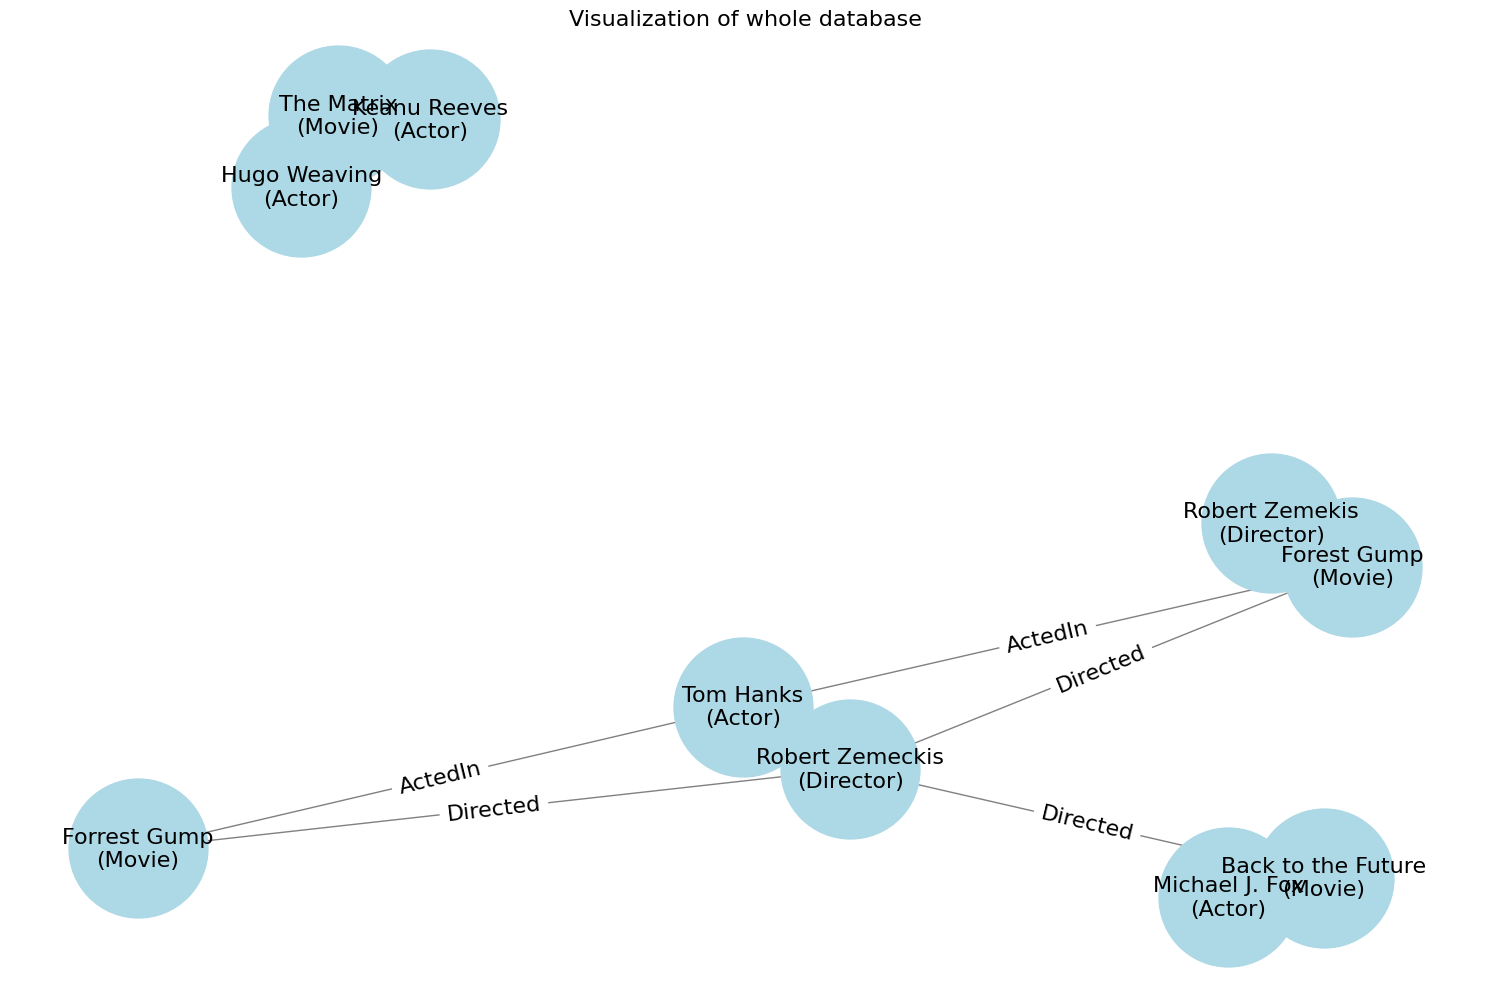

In [23]:
plt.figure(figsize=(15, 10))
draw_neo4j_graph()
plt.title("Visualization of whole database", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

The above display is a little cluttered.

If you are running this notebook locally you can head over to your neo4j and explore via interactive views like this:

![neo4j screenshot of more edges](../images/neo4j-screenshot-2.png)

## Queries

The graph can be queried the same as any other database in linkml-store. Note that at this time we don't expose a graph-oriented API,
we instead expose everything as node or edge collections. This has some advantages and disadvantages. The goal is not to replace something
like Cypher (you can and should of course just do Cypher queries over the underlying neoj4 database if and when you need to).

Let's start by querying for the entire contents of both collections:

In [24]:
node_collection.find().rows_dataframe

,name,id,category,born,released
0,Forest Gump,MOVIE:FG,Movie,NaN,NaN
1,Forest Gump (Character),CHARACTER:FGC,Character,NaN,NaN
2,Tom Hanks,PERSON:TH,Actor,1956.0,NaN
3,Robert Zemeckis,PERSON:RZ,Director,1951.0,NaN
4,Hugo Weaving,PERSON:HW,Actor,1960.0,NaN
5,Keanu Reeves,PERSON:KR,Actor,1964.0,NaN
6,Michael J. Fox,PERSON:MJF,Actor,1961.0,NaN
7,Forrest Gump,MOVIE:FG,Movie,NaN,1994.0
8,Back to the Future,MOVIE:BTTF,Movie,NaN,1985.0
9,Tom Hanks,ACTOR:TH,Actor,NaN,NaN


In [25]:
edge_collection.find().rows_dataframe

,subject,predicate,object,plays
0,ACTOR:RZ,Directed,MOVIE:FG,NaN
1,ACTOR:TH,ActedIn,MOVIE:FG,CHARACTER:FGC
2,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
3,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
4,PERSON:RZ,Directed,MOVIE:FG,NaN
5,PERSON:RZ,Directed,MOVIE:FG,NaN
6,PERSON:RZ,Directed,MOVIE:BTTF,NaN
7,PERSON:KR,ActedIn,MOVIE:TM,CHARACTER:Neo
8,PERSON:MJF,ActedIn,MOVIE:BTTF,CHARACTER:MartyMcFly
9,PERSON:HW,ActedIn,MOVIE:TM,CHARACTER:AgentSmith


We can also use standard key-value mongodb-like queries; over nodes:

In [26]:
node_collection.find({"category": "Actor"}).rows_dataframe

,born,name,id,category
0,1956.0,Tom Hanks,PERSON:TH,Actor
1,1960.0,Hugo Weaving,PERSON:HW,Actor
2,1964.0,Keanu Reeves,PERSON:KR,Actor
3,1961.0,Michael J. Fox,PERSON:MJF,Actor
4,NaN,Tom Hanks,ACTOR:TH,Actor


over edges:

In [27]:
edge_collection.find({"predicate": "ActedIn"}).rows_dataframe

,subject,predicate,object,plays
0,ACTOR:TH,ActedIn,MOVIE:FG,CHARACTER:FGC
1,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
2,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
3,PERSON:KR,ActedIn,MOVIE:TM,CHARACTER:Neo
4,PERSON:MJF,ActedIn,MOVIE:BTTF,CHARACTER:MartyMcFly
5,PERSON:HW,ActedIn,MOVIE:TM,CHARACTER:AgentSmith


## Facet Counts

We can also do basic analytic queries such as Solr-style facet grouping and counting.

We'll make use of a lightweight function that converts linkml-store facet counts to dataframes:

In [28]:
from linkml_store.utils.pandas_utils import facet_summary_to_dataframe_unmelted

In [29]:
r = node_collection.query_facets(facet_columns=["category"])
facet_summary_to_dataframe_unmelted(r)

,category,Value
0,Movie,6
1,Actor,5
2,Director,2
3,Character,1


In [30]:
# TODO: implement facet counts for edges
#r = edge_collection.query_facets(facet_columns=["subject", "predicate", "object"])
#facet_summary_to_dataframe_unmelted(r)

## Indexing via LLM embeddings

Neo4j can be indexed and search via LLM embeddings, just like any other linkml-store wrapped database.

__TODO__ show examples